In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

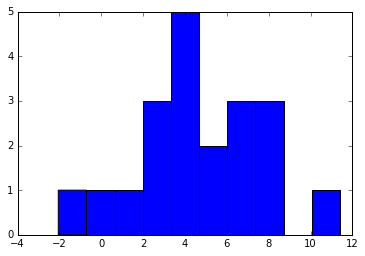

In [2]:
n = 20
sigma = 4
mu_x = 5
x = sp.stats.norm(mu_x,sigma).rvs(size=n,random_state=15) # random_state ensures the same sample is generated
plt.hist(x)
plt.show()

# Understanding the prior and the posterior

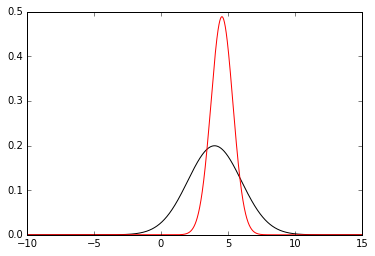

In [3]:
mu_hat = np.mean(x)

mu_a = 4
sigma_a = 2

def ComputePosteriorParams(mu_hat,m_a,s_a):
    h_0 = (sigma**2/n)**(-1)
    h_a = (s_a**2)**(-1)
    E_mu = (h_0*mu_hat + h_a*m_a)/(h_0 + h_a)
    D_mu = 1/(h_0 + h_a)
    return E_mu, D_mu

def plotPriorPosterior(m_a,s_a):   
    E_mu,D_mu = ComputePosteriorParams(mu_hat,m_a,s_a)
    rng = np.arange(-10,15,0.01)
    plt.plot(rng,sp.stats.norm(m_a,s_a).pdf(rng),'k',label="Prior")
    plt.plot(rng,sp.stats.norm(E_mu,np.sqrt(D_mu)).pdf(rng),'r',label="Posterior")
    plt.show()
    
wPP = interactive(plotPriorPosterior,
                  m_a = widgets.FloatSlider(min=mu_x-10,max=mu_x+10,step=0.01,value = mu_a, description="$\mu_a$",continuous_update=False),
                  s_a = widgets.FloatSlider(min=0.0001,max=10,step=0.01,value=sigma_a,description="$\sigma_a$",continuous_update=False))
display(wPP)

## Creating a random variable with the posterior distribution

In [4]:
PosteriorMean,PosteriorVariance = ComputePosteriorParams(mu_hat,mu_a,sigma_a)
PosteriorStdev = np.sqrt(PosteriorVariance)
PostMuRV = sp.stats.norm(loc=PosteriorMean,scale=PosteriorStdev)

# Point estimates

"Traditional" estimates like the mode and the median are easy in this case: they all coincide with the posterior mean.

In [5]:
print("The posterior mean/mode/median is %4.2f."%(PosteriorMean))

The posterior mean/mode/median is 4.55.


# Credible regions

In [6]:
ConfidenceLevel = 0.9

# We can minimize the interval that has the specified probability ConfidenceLevel.
# This shows the general approach to get the credible region.
res = sp.optimize.minimize(lambda x:x[1]-x[0], 
                     np.array([PosteriorMean-2,PostMuRV.ppf(ConfidenceLevel-PostMuRV.cdf(PosteriorMean-2))]),
                     constraints = {'type':'eq',
                                    'fun': lambda x:PostMuRV.cdf(x[1])-PostMuRV.cdf(x[0])-ConfidenceLevel
                                   })
lower,upper = res.x

# Or we can exploit the fact that in this case our posterior is normally distributed
# and directly obtain the interval for the specified probability.
lwr,upr = PostMuRV.interval(ConfidenceLevel)

print("""Computed with our numerical implementation, the %4.1f%% credible region is [%4.2f,%4.2f].
Computed using SciPy's interval() method, the %4.1f%% credible region is [%4.2f,%4.2f]."""
      %(ConfidenceLevel*100,lower,upper,ConfidenceLevel*100,lwr,upr))

Computed with our numerical implementation, the 90.0% credible region is [3.21,5.89].
Computed using SciPy's interval() method, the 90.0% credible region is [3.21,5.89].


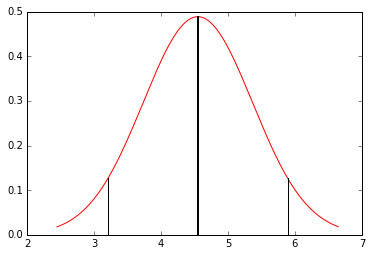

In [7]:
rng = np.arange(PostMuRV.interval(.99)[0],PostMuRV.interval(.99)[1],0.01)
plt.plot(rng,PostMuRV.pdf(rng),'r')
plt.plot([lwr,lwr],[0,PostMuRV.pdf(lwr)],'k')
plt.plot([upr,upr],[0,PostMuRV.pdf(upr)],'k')
plt.plot([PosteriorMean,PosteriorMean],[0,PostMuRV.pdf(PosteriorMean)],'k',linewidth=2)
plt.show()

# Hypothesis testing

In [8]:
from scipy.integrate import quad
def MargLikFunc(x,sigma,m_a,s_a):
    def integrand(mu):
        return scipy.stats.multivariate_normal.pdf(x,mean=mu*np.ones(x.size),cov=sigma**2)*scipy.stats.norm.pdf(mu,m_a,s_a)
    return quad(integrand,-100,100)[0]

BayesFactor = MargLikFunc(x,sigma,mu_a,sigma_a)/MargLikFunc(x,sigma,10,sigma_a)
print(BayesFactor)
# print(1/BayesFactor)

17.122279031732457
